In [1]:
from fit.datamodules.tomo_rec import MNISTTomoFourierTargetDataModule
from fit.utils import convert2FC, fft_interpolate, psfft, convert_to_dft, PSNR
from fit.utils.tomo_utils import get_proj_coords_pol, get_img_coords_pol
from matplotlib import pyplot as plt

import torch

import numpy as np

from skimage.transform import iradon

from fit.utils.utils import denormalize

from fit.modules import TRecTransformerModule

from matplotlib import gridspec

In [2]:
batch_size = 1
num_angles = 7
img_shape = 27
inner_circle = True

In [3]:
n = 8 # For mnist 2
# n = 12 # For mnist 9

In [4]:
dm = MNISTTomoFourierTargetDataModule(root_dir='/data/mnist/', batch_size=batch_size, 
                                      num_angles=num_angles, inner_circle=inner_circle)
dm.setup()

train_dl = dm.train_dataloader()

i = 0
for sino, img  in train_dl.dataset.ds:
    if i >= n:
        break
    i += 1

In [5]:
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times'], 'size':14})
rc('text', usetex=True)

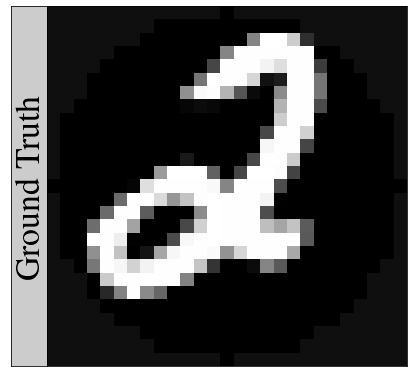

In [6]:
fig = plt.figure(figsize=(11/2., 10/2.)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1,10]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0, wspace = 0)

ax0.xaxis.set_major_locator(plt.NullLocator())
ax0.yaxis.set_major_locator(plt.NullLocator())
ax0.set_facecolor('#cccccc')
ax0.text(0.55,0.5, r'Ground Truth', fontsize=34, rotation='vertical', va='center', ha='center')

ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.yaxis.set_major_locator(plt.NullLocator())
ax1.imshow(img, cmap='gray', vmin=img.min(), vmax=img.max())
ax1.axis('equal');

fig.savefig('{}_gt.svg'.format(n), bbox_inches='tight', pad_inches=0.0)

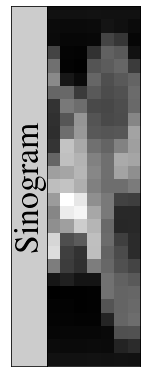

In [7]:
total_width = 11*27/10
fig = plt.figure(figsize=((1 + 7/27 * 10)/2., 10/2.)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 7/27*10]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0, wspace = 0)

ax0.xaxis.set_major_locator(plt.NullLocator())
ax0.yaxis.set_major_locator(plt.NullLocator())
ax0.set_facecolor('#cccccc')
ax0.text(0.55,0.5, r'Sinogram', fontsize=34, rotation='vertical', va='center', ha='center')

ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.yaxis.set_major_locator(plt.NullLocator())
ax1.imshow(sino.T, cmap='gray')
ax1.axis('equal');

fig.savefig('{}_sinogram.svg'.format(i), bbox_inches='tight', pad_inches=0.0)

In [8]:
dm = MNISTTomoFourierTargetDataModule(root_dir='/data/mnist/', batch_size=1, 
                                      num_angles=num_angles, inner_circle=inner_circle)
dm.setup()

In [9]:
train_dl = dm.train_dataloader()

# x and y are normalized magnitude and angle of the Fourier coefficients
i = 0
for x, fbp, y, y_real, (mag_min, mag_max) in train_dl:
    if i >= n:
        break
        
    i += 1

In [10]:
x_fc = convert2FC(x, mag_min, mag_max)
fbp_fc = convert2FC(fbp, mag_min, mag_max)
y_fc = convert2FC(y, mag_min, mag_max)

In [11]:
det_len = dm.gt_ds.get_ray_trafo().geometry.detector.shape[0]

In [12]:
srcx, srcy, src_flatten_order = get_proj_coords_pol(angles=dm.gt_ds.get_ray_trafo().geometry.angles, 
                                                          det_len=det_len)
dstx, dsty, dst_flatten_order, order = get_img_coords_pol(img_shape=dm.IMG_SHAPE, det_len=det_len)

In [13]:
x_fc.shape

torch.Size([1, 98])

In [14]:
from fit.utils.tomo_utils import pol2cart

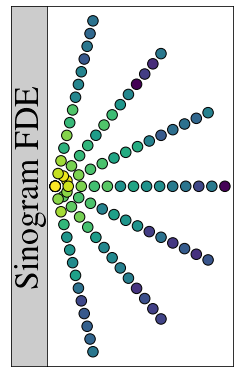

In [15]:
total_width = 11*27/10
fig = plt.figure(figsize=((1 + 14/27 * 10)/2., 10/2.)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 14/27*10]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0, wspace = 0)

ax0.xaxis.set_major_locator(plt.NullLocator())
ax0.yaxis.set_major_locator(plt.NullLocator())
ax0.set_facecolor('#cccccc')
ax0.text(0.55,0.5, r'Sinogram FDE', fontsize=34, rotation='vertical', va='center', ha='center')

ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.yaxis.set_major_locator(plt.NullLocator())
ax1.scatter(*pol2cart(srcx, srcy),
            c=torch.log(x_fc[0].abs())[src_flatten_order], cmap='viridis', s=110, edgecolor='black',
           linewidth=1)
ax1.axis('equal');

fig.savefig('{}_sinogram_fd.svg'.format(i), bbox_inches='tight', pad_inches=0.0)

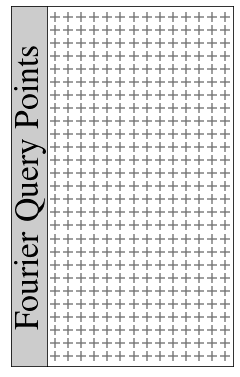

In [16]:
total_width = 11*27/10
fig = plt.figure(figsize=((1 + 14/27 * 10)/2., 10/2.)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 14/27*10]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0, wspace = 0)

ax0.xaxis.set_major_locator(plt.NullLocator())
ax0.yaxis.set_major_locator(plt.NullLocator())
ax0.set_facecolor('#cccccc')
ax0.text(0.55,0.5, r'Fourier Query Points', fontsize=34, rotation='vertical', va='center', ha='center')

ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.yaxis.set_major_locator(plt.NullLocator())
ax1.scatter(*pol2cart(dstx, dsty), marker='+', label='Projection Coordinates', 
           c='gray', s=100)
ax1.axis('equal');

fig.savefig('fourier_query_points.svg', bbox_inches='tight', pad_inches=0.0)

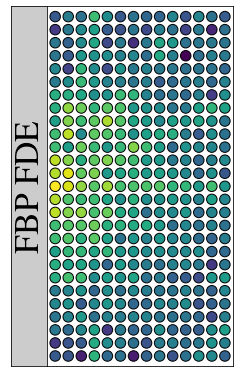

In [17]:
total_width = 11*27/10
fig = plt.figure(figsize=((1 + 14/27 * 10)/2., 10/2.)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 14/27*10]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0, wspace = 0)

ax0.xaxis.set_major_locator(plt.NullLocator())
ax0.yaxis.set_major_locator(plt.NullLocator())
ax0.set_facecolor('#cccccc')
ax0.text(0.55,0.5, r'FBP FDE', fontsize=34, rotation='vertical', va='center', ha='center')

ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.yaxis.set_major_locator(plt.NullLocator())
ax1.scatter(*pol2cart(dstx, dsty), c=torch.log(fbp_fc[0].abs())[dst_flatten_order], cmap='viridis', 
            s=110, edgecolor='black',linewidth=1)
ax1.axis('equal');

fig.savefig('{}_fbp_fde.svg'.format(i), bbox_inches='tight', pad_inches=0.0)

In [18]:
model = TRecTransformerModule.load_from_checkpoint('/home/tbuchhol/HaarVAE/FIT_experiments/iccv_experiments/TRec/trec_mnist_v0.1.24_fbp_prod_dconv8_nh8_dq32_icTrue_ibf2_bfc5_nl4_me300_ta7_pc/lightning_logs/version_39398335/checkpoints/best_val_loss_-epoch=298-step=513980.ckpt', 
                           y_coords_proj=srcx,
                           x_coords_proj=srcy,
                           y_coords_img=dstx,
                           x_coords_img=dsty,
                           angles=dm.gt_ds.get_ray_trafo().geometry.angles,
                           src_flatten_coords=src_flatten_order,
                           dst_flatten_coords=dst_flatten_order,
                           dst_order=order)

In [19]:
model.bin_factor = 1

In [20]:
x_fc_, fbp_fc_, y_fc_ = model._bin_data(x, fbp, y)

pred_fc, pred_img = model.trec.forward(x_fc_, fbp_fc_, mag_min=mag_min, mag_max=mag_max,
                                dst_flatten_coords=model.dst_flatten_coords,
                                img_shape=model.hparams.img_shape,
                                attenuation=model.mask)

/home/tbuchhol/.local/lib/python3.7/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [21]:
tmp = convert2FC(pred_fc, mag_min, mag_max)
print(tmp.shape)
pred_fc_ = torch.ones(x.shape[0], img_shape * (img_shape // 2 + 1), dtype=x.dtype, device=x.device)
pred_fc_[:,:tmp.shape[1]] = tmp

torch.Size([1, 378])


/home/tbuchhol/Programs/miniconda3/envs/ft/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /pytorch/aten/src/ATen/native/Copy.cpp:162.)
  after removing the cwd from sys.path.


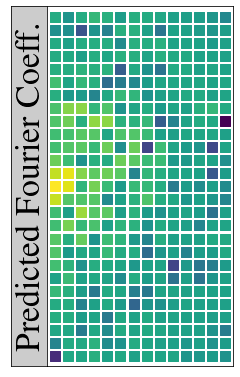

In [22]:
total_width = 11*27/10
fig = plt.figure(figsize=((1 + 14/27 * 10)/2., 10/2.)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 14/27*10]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0, wspace = 0)

ax0.xaxis.set_major_locator(plt.NullLocator())
ax0.yaxis.set_major_locator(plt.NullLocator())
ax0.set_facecolor('#cccccc')
ax0.text(0.55,0.5, r'Predicted Fourier Coeff.', fontsize=34, rotation='vertical', va='center', ha='center')

ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.yaxis.set_major_locator(plt.NullLocator())
ax1.scatter(*pol2cart(dstx, dsty), marker='s', label='Projection Coordinates', 
           c=torch.log(pred_fc_[0].abs().detach().cpu()), cmap='viridis', s=100)
ax1.axis('equal');

fig.savefig('{}_fourier_coefficient_prediction.svg'.format(i), bbox_inches='tight', pad_inches=0.0)

In [23]:
dft_pred_fc = convert_to_dft(fc=pred_fc, mag_min=mag_min, mag_max=mag_max,
                                    dst_flatten_coords=model.dst_flatten_coords, img_shape=model.hparams.img_shape)
# dft_pred_fc *= model.mask
img_pred_fc = torch.roll(torch.fft.irfftn(dft_pred_fc, dim=[1, 2], s=2 * (model.hparams.img_shape,)),
                      2 * (model.hparams.img_shape // 2,), (1, 2))

In [24]:
rec = iradon(sino.T, theta=-np.rad2deg(dm.gt_ds.get_ray_trafo().geometry.angles)).T

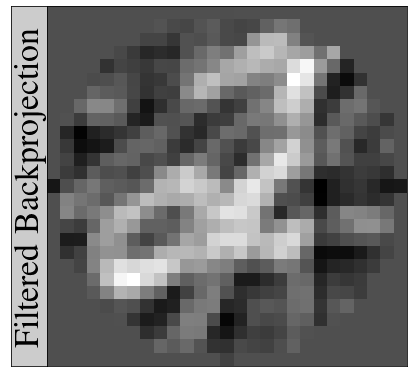

In [25]:
fig = plt.figure(figsize=(11/2., 10/2.)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1,10]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0, wspace = 0)

ax0.xaxis.set_major_locator(plt.NullLocator())
ax0.yaxis.set_major_locator(plt.NullLocator())
ax0.set_facecolor('#cccccc')
ax0.text(0.55,0.5, r'Filtered Backprojection', fontsize=34, rotation='vertical', va='center', ha='center')

ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.yaxis.set_major_locator(plt.NullLocator())
# rec = denormalize(torch.from_numpy(rec), dm.mean, dm.std)
# rec *= model.circle
ax1.imshow(rec, cmap='gray')#, vmin=img.min(), vmax=img.max())
ax1.axis('equal');

fig.savefig('{}_fbp.svg'.format(i), bbox_inches='tight', pad_inches=0.0)

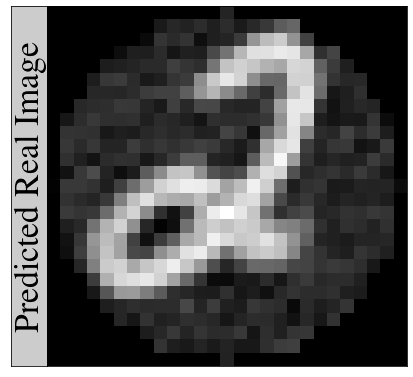

In [26]:
fig = plt.figure(figsize=(11/2., 10/2.)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1,10]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0, wspace = 0)

ax0.xaxis.set_major_locator(plt.NullLocator())
ax0.yaxis.set_major_locator(plt.NullLocator())
ax0.set_facecolor('#cccccc')
ax0.text(0.55,0.5, r'Predicted Real Image', fontsize=34, rotation='vertical', va='center', ha='center')

ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.yaxis.set_major_locator(plt.NullLocator())
pred = img_pred_fc[-1].detach()
pred = denormalize(pred, dm.mean, dm.std)
pred *= model.circle
ax1.imshow(pred, cmap='gray')#, vmin=img.min(), vmax=img.max())
ax1.axis('equal');

fig.savefig('{}_real_img_pred_beforeConv.svg'.format(i), bbox_inches='tight', pad_inches=0.0)

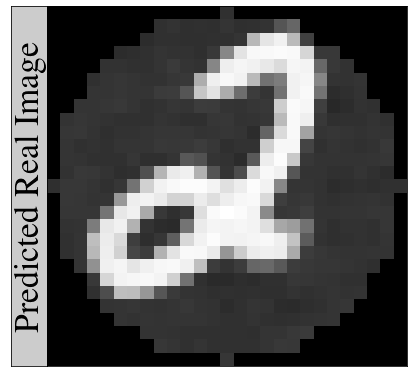

In [27]:
fig = plt.figure(figsize=(11/2., 10/2.)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1,10]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0, wspace = 0)

ax0.xaxis.set_major_locator(plt.NullLocator())
ax0.yaxis.set_major_locator(plt.NullLocator())
ax0.set_facecolor('#cccccc')
ax0.text(0.55,0.5, r'Predicted Real Image', fontsize=34, rotation='vertical', va='center', ha='center')

ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.yaxis.set_major_locator(plt.NullLocator())
pred = pred_img[0].detach()
pred = denormalize(pred, dm.mean, dm.std)
pred *= model.circle
ax1.imshow(pred.numpy(), cmap='gray')#, vmin=img.min(), vmax=img.max())
ax1.axis('equal');

fig.savefig('{}_real_img_pred.svg'.format(i), bbox_inches='tight', pad_inches=0.0)

In [28]:
y_fc_ = convert2FC(y_fc_, mag_min, mag_max)

In [29]:
y_fc_sample = torch.ones(y.shape[0], img_shape * (img_shape // 2 + 1), dtype=x.dtype, device=x.device)
y_fc_sample[:,:y_fc_.shape[1]] = y_fc_

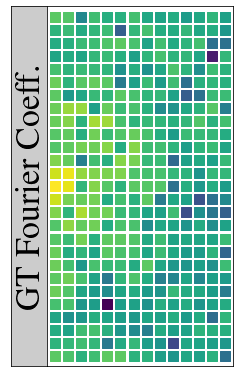

In [30]:
total_width = 11*27/10
fig = plt.figure(figsize=((1 + 14/27 * 10)/2., 10/2.)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 14/27*10]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0, wspace = 0)

ax0.xaxis.set_major_locator(plt.NullLocator())
ax0.yaxis.set_major_locator(plt.NullLocator())
ax0.set_facecolor('#cccccc')
ax0.text(0.55,0.5, r'GT Fourier Coeff.', fontsize=34, rotation='vertical', va='center', ha='center')

ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.yaxis.set_major_locator(plt.NullLocator())
ax1.scatter(*pol2cart(dstx, dsty), marker='s', label='Projection Coordinates', 
           c=torch.log(y_fc_sample[0].abs().detach().cpu()), cmap='viridis', s=100)
ax1.axis('equal');

fig.savefig('{}_fourier_coefficient_target.svg'.format(i), bbox_inches='tight', pad_inches=0.0)